In [1]:
import torch
import intel_extension_for_pytorch as ipex

C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\intel\miniforge3\envs\bertviz\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from transformers import BertModel, BertTokenizer
model_name = 'bert-base-uncased'
model = BertModel.from_pretrained(model_name,add_pooling_layer = False).to('xpu').eval()
tokenizer = BertTokenizer.from_pretrained(model_name)
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [119]:
embedding_weight=model.embeddings.word_embeddings.weight.detach()
embedding_weight.shape

torch.Size([30522, 768])

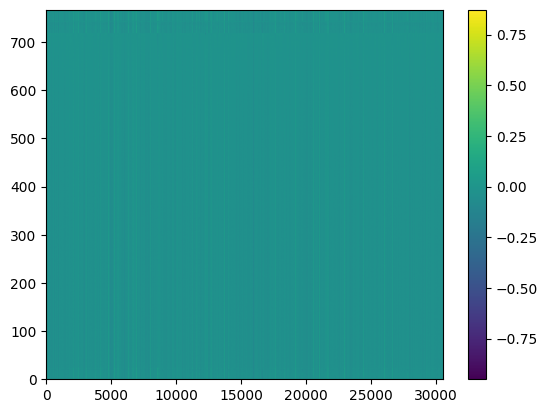

In [120]:
import matplotlib.pyplot as plt
plt.imshow(embedding_weight.cpu().numpy(), extent=[0,30521,0,767],aspect='auto')
plt.colorbar()

In [121]:
tokenizer('cat')

{'input_ids': [101, 4937, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

In [141]:
toks_ids = [tokenizer.encode(t)[1] for t in ['cat','dog',' dog','boat','man']]
toks_names = [tokenizer.decode(t) for t in toks_ids]
toks_names

['c a t', 'd o g', 'd o g', 'b o a t', 'm a n']

In [142]:
embedding_weight[toks_ids].shape

torch.Size([5, 768])

In [143]:
def calc_dist(embeddings):
    normed = embeddings/(embeddings*embeddings).mean(1).sqrt()[:,None]
    cosine_dist = normed@normed.T/normed.shape[1]
    return cosine_dist.cpu().numpy()

In [144]:
dist = calc_dist(embedding_weight[toks_ids])
dist

array([[1.0000001 , 0.50815105, 0.50815105, 0.27609736, 0.3458391 ],
       [0.50815105, 0.9999999 , 0.9999999 , 0.3820202 , 0.34203348],
       [0.50815105, 0.9999999 , 0.9999999 , 0.3820202 , 0.34203348],
       [0.27609736, 0.3820202 , 0.3820202 , 0.9999999 , 0.25997663],
       [0.3458391 , 0.34203348, 0.34203348, 0.25997663, 0.99999976]],
      dtype=float32)

In [145]:
import numpy as np

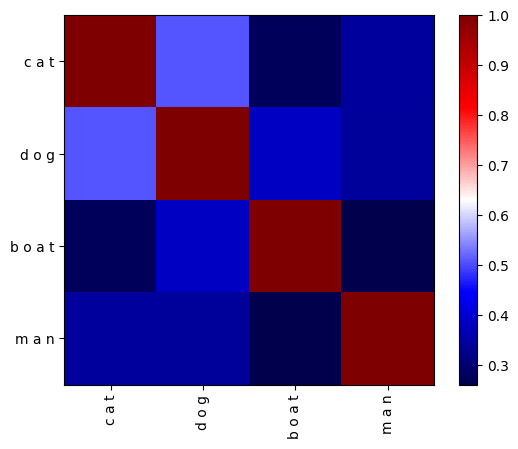

In [140]:
plt.imshow(dist,cmap='seismic')
plt.xticks(range(len(toks_names)), toks_names, rotation=90)
plt.yticks(range(len(toks_names)), toks_names)
plt.colorbar()

In [24]:
@torch.no_grad
def embed(text):
    inputs=tokenizer(text,return_tensors='pt',padding=True)
    inputs={k:v.to('xpu') for k,v in inputs.items()}
    return model(**inputs).last_hidden_state.mean([1])

embed(['hey','whats up']).shape

torch.Size([2, 768])

In [78]:
phrases = ['cat','dog','go for it','you can do this']
embedings = embed(phrases)
dist=calc_dist(embedings)
dist

array([[1.0000001 , 0.8765118 , 0.49203557, 0.398526  ],
       [0.8765118 , 0.99999994, 0.49319267, 0.3863066 ],
       [0.49203557, 0.49319267, 1.0000002 , 0.65687543],
       [0.398526  , 0.3863066 , 0.65687543, 0.9999999 ]], dtype=float32)

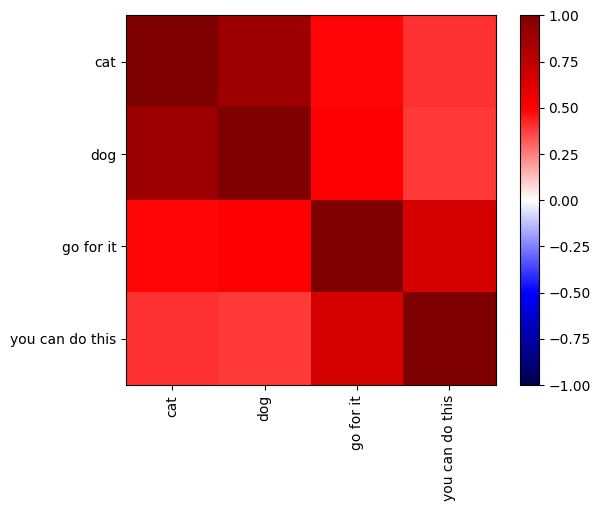

In [117]:
plt.imshow(dist,cmap='seismic',vmin=-1,vmax=1)
plt.xticks(range(len(phrases)), phrases, rotation=90)
plt.yticks(range(len(phrases)), phrases)
plt.colorbar()

In [80]:
wikipedia_philosophy='''Philosophy (love of wisdom in ancient Greek) is a systematic study of general and fundamental questions concerning topics like existence, reason, knowledge, value, mind, and language. It is a rational and critical inquiry that reflects on its own methods and assumptions.

Historically, many of the individual sciences, like physics and psychology, formed part of philosophy. But they are considered separate academic disciplines in the modern sense of the term. The main traditions in the history of philosophy include Western, Arabic-Persian, Indian, and Chinese philosophy. Western philosophy originated in Ancient Greece and covers a wide area of philosophical subfields. A central topic in Arabic-Persian philosophy is the relation between reason and revelation. Indian philosophy combines the spiritual problem of how to reach enlightenment with the exploration of the nature of reality and the ways of arriving at knowledge. Chinese philosophy focuses on practical issues in relation to right social conduct, government, and self-cultivation.

Major branches of philosophy are epistemology, ethics, logic, and metaphysics. Epistemology studies what knowledge is and how to acquire it. Ethics investigates moral principles and what constitutes right conduct. Logic is the study of correct reasoning and explores how good arguments can be distinguished from bad ones. Metaphysics examines the most general features of reality, existence, objects, and properties. Other notable subfields are aesthetics, philosophy of language, philosophy of mind, philosophy of religion, philosophy of science, philosophy of history, and political philosophy.

Philosophers use a great variety of methods to arrive at philosophical knowledge. They include conceptual analysis, reliance on common sense and intuitions, use of thought experiments, analysis of ordinary language, description of experience, and critical questioning. Philosophy is related to many other fields, like the sciences, mathematics, business, law, and journalism. It provides an interdisciplinary perspective and studies their scope and fundamental concepts. It also investigates their methods and ethical implications'''


In [81]:
labels = phrases[:]
labels.append('wikipedia article')
labels

['cat', 'dog', 'go for it', 'you can do this', 'wikipedia article']

In [82]:
texts = phrases[:]
texts.append(wikipedia_philosophy)
len(texts)

5

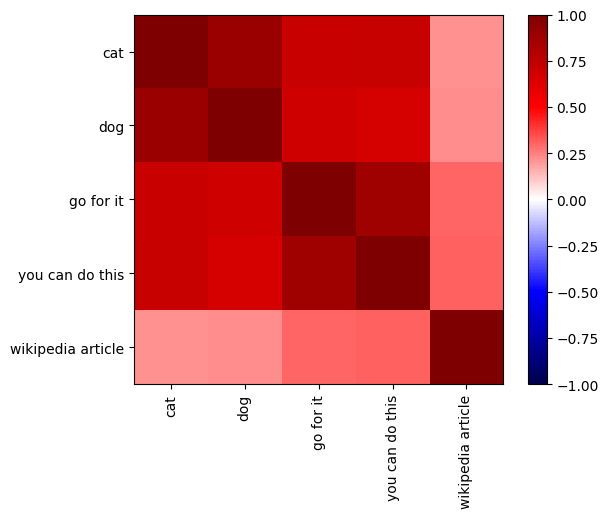

In [83]:
plt.imshow(calc_dist(embed(texts)),cmap='seismic',vmin=-1,vmax=1)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.colorbar()